## Load libraries

In [ ]:
!pip install -r requirements.txt

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns

from PIL import Image

import torch
import torch.nn as nn
import torch.utils.data as D
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F
from torch.autograd import Variable
from multiprocessing import Pool, cpu_count

from torchvision import transforms

from ignite.engine import Events
from scripts.ignite import create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Loss, Accuracy
from ignite.contrib.handlers.tqdm_logger import ProgressBar
from ignite.handlers import  EarlyStopping, ModelCheckpoint
from ignite.contrib.handlers import LinearCyclicalScheduler, CosineAnnealingScheduler

import random

from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split

from efficientnet_pytorch import EfficientNet, utils as enet_utils

from scripts.evaluate import eval_model
from scripts.transforms import gen_transform_train_wo_norm
from scripts.plates_leak import apply_plates_leak

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
!ls /storage

lost+found  rxrxai  rxrxkey.txt  rxrxmodels


In [3]:
!ls /storage/rxrxai

pixel_stats.csv		       test.csv		  train.zip
pixel_stats.csv.zip	       test.zip		  train384
pixel_stats_agg.csv	       test_controls.csv  train_controls.csv
recursion_dataset_license.pdf  train		  training_aug.csv
sample_submission.csv	       train.csv	  validation.csv
test			       train.csv.zip


In [4]:
path_data = '/storage/rxrxai'
device = 'cuda'
batch_size = 4
torch.manual_seed(0)
model_name = 'efficientnet-b4'
init_lr = 3e-4
end_lr = 1e-7

In [5]:
# dataframes for training, cross-validation, and testing
df = pd.read_csv(path_data+'/train.csv')
df_test = pd.read_csv(path_data+'/test.csv')
df_all = pd.concat([df, df_test])
df_pixels = pd.read_csv(path_data+'/pixel_stats.csv')

In [6]:
def train_or_test(row):
    return 'train' if not np.isnan(row['sirna']) else 'test'

df_all['ds'] = df_all.apply(train_or_test, axis=1)
df_all.head()

,experiment,id_code,plate,sirna,well,ds
0,HEPG2-01,HEPG2-01_1_B03,1,513.0,B03,train
1,HEPG2-01,HEPG2-01_1_B04,1,840.0,B04,train
2,HEPG2-01,HEPG2-01_1_B05,1,1020.0,B05,train
3,HEPG2-01,HEPG2-01_1_B06,1,254.0,B06,train
4,HEPG2-01,HEPG2-01_1_B07,1,144.0,B07,train


In [7]:
df_all['cell'] = df_all.apply(lambda row: row['experiment'].split("-")[0], axis=1)
df_all.head(277*6)

,experiment,id_code,plate,sirna,well,ds,cell
0,HEPG2-01,HEPG2-01_1_B03,1,513.0,B03,train,HEPG2
1,HEPG2-01,HEPG2-01_1_B04,1,840.0,B04,train,HEPG2
2,HEPG2-01,HEPG2-01_1_B05,1,1020.0,B05,train,HEPG2
3,HEPG2-01,HEPG2-01_1_B06,1,254.0,B06,train,HEPG2
4,HEPG2-01,HEPG2-01_1_B07,1,144.0,B07,train,HEPG2
5,HEPG2-01,HEPG2-01_1_B08,1,503.0,B08,train,HEPG2
6,HEPG2-01,HEPG2-01_1_B09,1,188.0,B09,train,HEPG2
7,HEPG2-01,HEPG2-01_1_B10,1,700.0,B10,train,HEPG2
8,HEPG2-01,HEPG2-01_1_B11,1,1100.0,B11,train,HEPG2
9,HEPG2-01,HEPG2-01_1_B12,1,611.0,B12,train,HEPG2


In [49]:
df_all.tail()

,experiment,id_code,plate,sirna,well,ds,cell
19892,U2OS-05,U2OS-05_4_O19,4,NaN,O19,test,U2OS
19893,U2OS-05,U2OS-05_4_O20,4,NaN,O20,test,U2OS
19894,U2OS-05,U2OS-05_4_O21,4,NaN,O21,test,U2OS
19895,U2OS-05,U2OS-05_4_O22,4,NaN,O22,test,U2OS
19896,U2OS-05,U2OS-05_4_O23,4,NaN,O23,test,U2OS


In [50]:
train_length = len(df_all[df_all['ds'] == 'train'])

for cell in ['HEPG2', 'HUVEC', 'RPE', 'U2OS']:
    print(f"{cell} {df_all[df_all['ds'] == 'train'].groupby('cell').agg(['count'])[['experiment']].loc[cell][0] / train_length}")

HEPG2 0.21224154457072436
HUVEC 0.48440366972477067
RPE 0.21232370258797753
U2OS 0.09103108311652745


In [51]:
.01 * train_length

365.15000000000003

In [52]:
test_length = len(df_all[df_all['ds'] == 'test'])

for cell in ['HEPG2', 'HUVEC', 'RPE', 'U2OS']:
    print(f"{cell} {df_all[df_all['ds'] == 'test'].groupby('cell').agg(['count'])[['experiment']].loc[cell][0] / test_length}")

HEPG2 0.22259637131225812
HUVEC 0.4445896366286375
RPE 0.22199326531637936
U2OS 0.11082072674272503


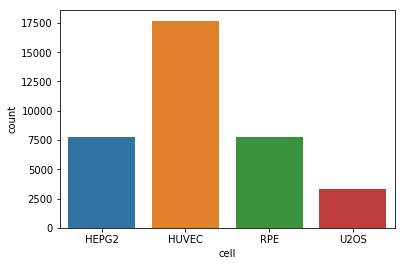

In [53]:
sns.countplot(x='cell',data=df_all[df_all['ds'] == 'train'])

In [54]:
df_all[df_all['ds'] == 'train'].groupby('cell').agg(['count'])

,experiment,id_code,plate,sirna,well,ds
,count,count,count,count,count,count
cell,,,,,,
HEPG2,7750,7750,7750,7750,7750,7750
HUVEC,17688,17688,17688,17688,17688,17688
RPE,7753,7753,7753,7753,7753,7753
U2OS,3324,3324,3324,3324,3324,3324


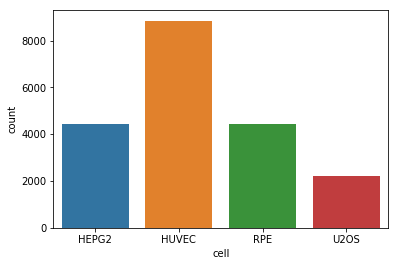

In [55]:
sns.countplot(x='cell',data=df_all[df_all['ds'] == 'test'])

In [56]:
df_all[df_all['ds'] == 'test'].groupby('cell').agg(['count'])

,experiment,id_code,plate,sirna,well,ds
,count,count,count,count,count,count
cell,,,,,,
HEPG2,4429,4429,4429,0,4429,4429
HUVEC,8846,8846,8846,0,8846,8846
RPE,4417,4417,4417,0,4417,4417
U2OS,2205,2205,2205,0,2205,2205


In [57]:
df_pixels.head()

,id_code,experiment,plate,well,site,channel,mean,std,median,min,max
0,HEPG2-01_1_B02,HEPG2-01,1,B02,1,1,71.063782,43.146240,67.0,7,255
1,HEPG2-01_1_B02,HEPG2-01,1,B02,1,2,32.174431,9.384594,31.0,6,98
2,HEPG2-01_1_B02,HEPG2-01,1,B02,1,3,61.836025,23.377997,59.0,11,255
3,HEPG2-01_1_B02,HEPG2-01,1,B02,1,4,56.983257,16.011435,56.0,11,156
4,HEPG2-01_1_B02,HEPG2-01,1,B02,1,5,91.671993,39.221836,85.0,13,255


In [58]:
df_pixels[['min']].min()

min    0
dtype: int64

In [59]:
df_pixels[df_pixels['min'] == df_pixels[['min']].max()[0]].head()

,id_code,experiment,plate,well,site,channel,mean,std,median,min,max
289009,HUVEC-09_3_E02,HUVEC-09,3,E02,1,2,77.361301,18.421216,71.0,53,255


In [60]:
df_pixels[df_pixels['min'] == df_pixels[['min']].min()[0]].head()

,id_code,experiment,plate,well,site,channel,mean,std,median,min,max
44380,HEPG2-04_1_B04,HEPG2-04,1,B04,1,5,2.099361,2.016894,1.0,0,32
44386,HEPG2-04_1_B04,HEPG2-04,1,B04,2,5,2.907871,2.342452,2.0,0,33
44392,HEPG2-04_1_B05,HEPG2-04,1,B05,1,5,2.140354,2.482237,1.0,0,225
44398,HEPG2-04_1_B05,HEPG2-04,1,B05,2,5,3.846188,2.685085,4.0,0,28
44404,HEPG2-04_1_B06,HEPG2-04,1,B06,1,5,2.967934,2.221915,3.0,0,33


In [61]:
print(len(df))

36515


In [62]:
df_pixels.groupby('channel').agg(['count'])    

,id_code,experiment,plate,well,site,mean,std,median,min,max
,count,count,count,count,count,count,count,count,count,count
channel,,,,,,,,,,
1,125510,125510,125510,125510,125510,125510,125510,125510,125510,125510
2,125510,125510,125510,125510,125510,125510,125510,125510,125510,125510
3,125510,125510,125510,125510,125510,125510,125510,125510,125510,125510
4,125510,125510,125510,125510,125510,125510,125510,125510,125510,125510
5,125510,125510,125510,125510,125510,125510,125510,125510,125510,125510
6,125510,125510,125510,125510,125510,125510,125510,125510,125510,125510


In [63]:
m = df_pixels[df_pixels['channel'] == 2]
m = m[m['experiment'].str.contains('HEPG2')]
m.tail()

,id_code,experiment,plate,well,site,channel,mean,std,median,min,max
162535,HEPG2-11_4_O21,HEPG2-11,4,O21,2,2,23.061954,12.409125,21.0,2,112
162541,HEPG2-11_4_O22,HEPG2-11,4,O22,1,2,9.546902,9.937065,6.0,2,145
162547,HEPG2-11_4_O22,HEPG2-11,4,O22,2,2,9.051575,10.988752,4.0,2,220
162553,HEPG2-11_4_O23,HEPG2-11,4,O23,1,2,11.207123,12.421270,6.0,2,141
162559,HEPG2-11_4_O23,HEPG2-11,4,O23,2,2,11.352909,13.563623,6.0,1,168


In [64]:
stats_data = {'cell': [], 'channel': [], 'std': [], 'mean': []}

stats_df = pd.DataFrame(data=stats_data)
for channel in range(1,7):
    temp = df_pixels[df_pixels['channel'] == channel]
    stats_df = stats_df.append({'cell': 'ALL', 'channel': int(channel), 'std': temp[["std"]].mean()[0], 'mean': temp[["mean"]].mean()[0]}, ignore_index=True)
    print(f'channel {channel} - mean: {temp[["mean"]].mean()[0]} | std: {temp[["std"]].mean()[0]}\n')
    
print(stats_df)

channel 1 - mean: 5.845691592341334 | std: 6.9056823714669875

channel 2 - mean: 15.567965862276298 | std: 12.556696025163996

channel 3 - mean: 10.10558293628062 | std: 5.584809318973713

channel 4 - mean: 9.964395871351234 | std: 7.445013704896161

channel 5 - mean: 5.57672050803717 | std: 4.668733754481159

channel 6 - mean: 9.06773161153738 | std: 4.91070227013248

  cell  channel        std       mean
0  ALL      1.0   6.905682   5.845692
1  ALL      2.0  12.556696  15.567966
2  ALL      3.0   5.584809  10.105583
3  ALL      4.0   7.445014   9.964396
4  ALL      5.0   4.668734   5.576721
5  ALL      6.0   4.910702   9.067732


In [65]:
for cell in ['HEPG2', 'HUVEC', 'RPE', 'U2OS']:
    print('\n\n')
    for channel in range(1,7):
        temp = df_pixels[df_pixels['channel'] == channel]
        temp = temp[temp['experiment'].str.contains(cell)]
        stats_df = stats_df.append({'cell': cell, 'channel': int(channel), 'std': temp[["std"]].mean()[0], 'mean': temp[["mean"]].mean()[0]}, ignore_index=True)
        print(f'channel {channel} {cell} - mean: {temp[["mean"]].mean()[0]} | std: {temp[["std"]].mean()[0]}\n')
        
print(stats_df)




channel 1 HEPG2 - mean: 11.031356732537494 | std: 12.383423263164476

channel 2 HEPG2 - mean: 15.786221102312357 | std: 11.940651802029715

channel 3 HEPG2 - mean: 12.883933155952173 | std: 7.404890056698376

channel 4 HEPG2 - mean: 15.145480148271501 | std: 10.083671129382434

channel 5 HEPG2 - mean: 11.517225424319587 | std: 7.959842438990438

channel 6 HEPG2 - mean: 11.841935962489181 | std: 6.836244188216102




channel 1 HUVEC - mean: 4.333631709629353 | std: 5.168027755364031

channel 2 HUVEC - mean: 15.80156420876473 | std: 13.100209123833368

channel 3 HUVEC - mean: 7.1570779968701 | std: 3.7150705725246076

channel 4 HUVEC - mean: 8.393391375691078 | std: 6.873972929357964

channel 5 HUVEC - mean: 2.821444750663893 | std: 3.022117393519594

channel 6 HUVEC - mean: 6.563911710411285 | std: 3.3992237249709327




channel 1 RPE - mean: 2.6980435886108265 | std: 3.515845198630972

channel 2 RPE - mean: 12.683445297258121 | std: 11.777622340405468

channel 3 RPE - mean: 12.57994

In [66]:
stats_df.to_csv('/storage/rxrxai/pixel_stats_agg.csv', index=False)

KeyboardInterrupt: 

In [ ]:
df_train_sirna = df_all[df_all['ds'] == 'train']
df_train_sirna.groupby('sirna').agg(['count'])

In [ ]:
# !cat /storage/rxrxai/sample_submission.csv`

# Images

In [ ]:
df_all.head()

In [ ]:
df_all.tail()

In [8]:
cpu_count()

12

In [9]:
df_all_records = df_all.to_records(index=False)

In [10]:
def get_img_path(index, channel, site, suffix=''):
    experiment, well, plate, ds = df_all_records[index].experiment, df_all_records[index].well, df_all_records[index].plate, df_all_records[index].ds
    return '/'.join(['/storage/rxrxai', f'{ds}{suffix}', experiment, f'Plate{int(plate)}', f'{well}_s{site}_w{channel}.png'])

transform = transforms.Compose([transforms.Resize(384)])

df_all_enum = enumerate(df_all_records)

def add_aug_images(packed_args):
    i, row = packed_args

    for channel in range(1,7):
        for site in [1,2]:
            experiment = df_all_records[i].experiment
            plate = df_all_records[i].plate
            ds = df_all_records[i].ds
            sub_dir = f'/storage/rxrxai/{ds}384/{experiment}/Plate{int(plate)}'

            if not os.path.exists(sub_dir):
                os.makedirs(sub_dir)

            with Image.open(get_img_path(i, channel, site)) as img:
                image = transform(img)
                image.save(get_img_path(i, channel, site, suffix='384'))

In [15]:
%%time
pool = Pool()                   
m = pool.map(add_aug_images, df_all_enum)

CPU times: user 799 ms, sys: 147 ms, total: 946 ms
Wall time: 963 ms


Process ForkPoolWorker-7:
Process ForkPoolWorker-1:
Process ForkPoolWorker-10:
Process ForkPoolWorker-11:
Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Process ForkPoolWorker-8:
Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Process ForkPoolWorker-9:
Process ForkPoolWorker-12:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6

In [ ]:
open("myfile.txt", "x")